In [21]:
import numpy as np
import pandas as pd
import lxml
import matplotlib.pyplot as plt
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

## Lets get the stock market data over last year from yahoo

In [22]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

# payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# first_table = payload[0]
# second_table = payload[1]

# df = first_table
# df.head()
# my_stocks = df['Symbol'].values.tolist()
# n = len(my_stocks)
# my_stocks.remove('BRK.B')
# my_stocks.remove('BF.B')
# my_stocks.remove('CARR')
# my_stocks.remove('LUMN')
# my_stocks.remove('OTIS')
# my_stocks.remove('VNT')
my_stocks = ['AAPL','BA','FB','GILD','REGI','SBUX','TWTR','DIS','GE','HD','DAL','GOOG','ABBV','JNJ','NEE','TSLA','SPY','GLD','F','AMGN','NKE']

In [24]:
import urllib.request

print('Downloading data...')

for symbol in my_stocks:
    url = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1583884800&period2=1609113600&interval=1d&events=history&includeAdjustedClose=true'
    urllib.request.urlretrieve(url,'../data/'+symbol+'.csv')

## Now read the data using pandas

In [26]:
my_dict = {}
for symbol in my_stocks:
    my_dict[symbol] = pd.read_csv('../data/'+symbol+'.csv')

n = len(my_dict)
T = my_dict[symbol].shape[0]

my_dict['TWTR'].tail()

,Date,Open,High,Low,Close,Adj Close,Volume
197,2020-12-18,54.93,56.080002,54.270000,55.869999,55.869999,20450300
198,2020-12-21,54.50,55.680000,53.580002,54.639999,54.639999,10349400
199,2020-12-22,55.00,55.680000,54.369999,54.910000,54.910000,9259200
200,2020-12-23,55.34,55.450001,54.230000,54.299999,54.299999,6008600
201,2020-12-24,54.52,55.189999,53.860001,53.970001,53.970001,3661100


In [27]:
stocks = np.zeros([n,T])
for i, symbol in enumerate(my_stocks):
    try:
        stocks[i,:] = np.float32(my_dict[symbol].Close)
    except:
        print("some problem for data of",symbol)

times =  my_dict[symbol].Date

## Online newton step algorithm and expert

In [28]:
x = np.ones(n)/n
f = np.zeros(T)

# Parameter Free Expert
sum_g_tild = np.zeros(n)
sum_g_w = np.zeros(n)
x_0 = np.ones(n)/n
for t in range(T-1):

    w = sum_g_tild /(t+T/2)*(1+sum_g_w)
    x = x_0 * np.maximum(w, 0)

    if np.sum(x) > 0:
        x = x / np.sum(x)
    else:
        x = x_0

    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = r/np.dot(x, r)

    g_tild = grad - np.dot(grad, x)
    g_tild[w<0] = np.maximum(g_tild[w<0], 0)

    sum_g_tild += g_tild
    sum_g_w += g_tild

log_wealth_expert = np.cumsum(-f)

x_pfe = x
biggest = np.argsort(x)
print('PFE portfolio')
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x_pfe[i]*100))+ '%')

PFE portfolio
TSLA	51.0%
REGI	27.53%
GE	5.84%
DAL	2.771%
DIS	2.174%
AAPL	2.111%
NKE	1.795%
F	1.78%
BA	1.711%
TWTR	1.67%
GLD	0.287%
GOOG	0.2854%
ABBV	0.2515%
SBUX	0.197%
SPY	0.1874%
NEE	0.1713%
AMGN	0.1647%
JNJ	0.0585%
HD	0.0%
GILD	0.0%
FB	0.0%


In [29]:
def project(y, A):
    n = y.size

    P = matrix(A, tc='d')
    q = matrix(-2*np.matmul(y, A), tc='d')
    G = matrix(-np.eye(n), tc='d')
    h = matrix(np.zeros(n), tc='d')
    A = matrix(np.ones([1,n]), tc='d')
    b = matrix([1], tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    return np.array(sol['x']).reshape(-1)

In [30]:
# ONS
alpha = 0.6
G = np.sqrt(n)/alpha
gamma = 1/8/G
epsilon = 1/gamma**2
# gamma = 1
# epsilon = 1/8

# Initialization
A = epsilon*np.eye(n)
x = np.ones(n)/n
f = np.zeros(T)

# Algorithms
for t in range(T-1):
    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = - r/np.dot(x, r)

    # ONS
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

log_wealth_ons = np.cumsum(-f)

x_ons = x

print('ONS portfolio')
biggest = np.argsort(x)
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x_ons[i]*100))+ '%')

ONS portfolio
REGI	100.0%
GE	1.025e-05%
DAL	9.24e-06%
F	9e-06%
BA	8.5e-06%
GILD	7.7e-06%
TWTR	6.14e-06%
FB	5.3e-06%
AMGN	5.3e-06%
ABBV	5.2e-06%
SBUX	4.8e-06%
NKE	4.7e-06%
DIS	4.2e-06%
JNJ	4.2e-06%
GLD	4e-06%
SPY	3.8e-06%
HD	3.8e-06%
GOOG	3.7e-06%
NEE	2.56e-06%
TSLA	2.2e-06%
AAPL	2.1e-06%


## Backtest results

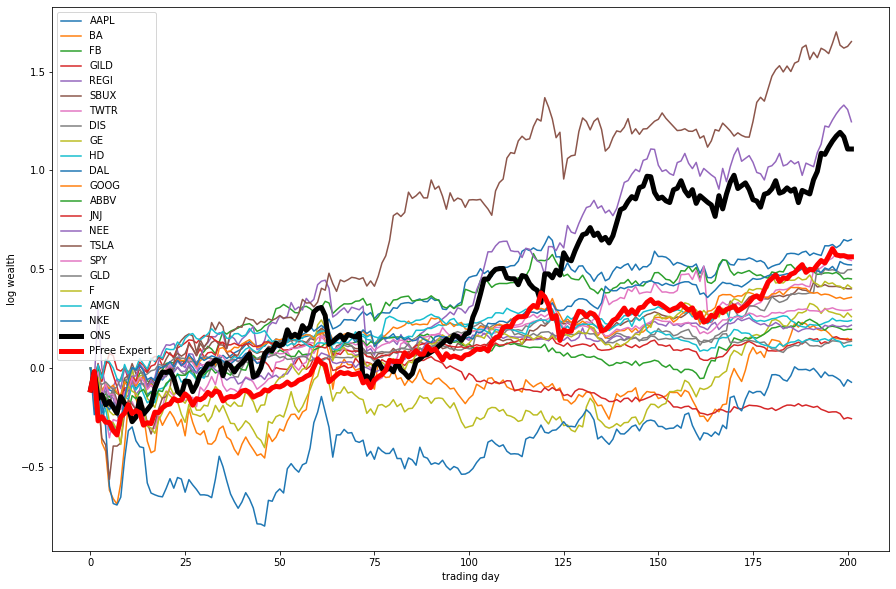

In [31]:
# Visualization
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

for i, symbol in enumerate(my_stocks):
    ax.plot(np.arange(T),np.log(stocks[i]) - np.log(stocks[i,0]), label=symbol)

ax.plot(np.arange(T), log_wealth_ons, 'k' , linewidth=5, label='ONS')
ax.plot(np.arange(T), log_wealth_expert, 'r' , linewidth=5, label='PFree Expert')

ax.legend()
ax.set_xlabel('trading day')
ax.set_ylabel('log wealth')
plt.show()